# Integração com o Comet.ml

Para conseguir rodar o código abaixo, além de ter todas as bibliotecas necessárias, entre em https://www.comet.ml/ e crie uma conta.
Após isso, substitua as credenciais na célula abaixo e nomeie o projeto como quiser.

In [ ]:
from comet_ml import Experiment
experiment = Experiment(
    api_key='',
    project_name="mae5904-rna",
    workspace='',
)
from pandas import read_csv, get_dummies, to_datetime
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import plot_model
from numpy import abs

Os dados usados no treino do modelo devem ser exportados do código em R e salvos com o nome "dados.csv" na mesma pasta que este notebook.

In [2]:
dados = read_csv('dados.csv', sep=',', encoding='UTF-8')

/home/martinoni/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dados['dataNotificacao'] = to_datetime(dados.dataNotificacao)
dados = dados.sort_values('dataNotificacao', ignore_index=True)
dados

,Unnamed: 0,ÿid,dataNotificacao,dataInicioSintomas,dataNascimento,sintomas,profissionalSaude,cbo,condicoes,estadoTeste,...,Assintomatico,Coriza,Dispneia,DistGustativos,DistOlfativos,DorDeCabeca,DorDeGarganta,Febre,Tosse,Outros
0,11195,PDLs9wrz96,2020-06-02,2020-05-26T03:00:00.000Z,2001-12-22T02:00:00.000Z,"Febre, Tosse, Dor de Garganta, Dispneia",Não,NaN,NaN,Concluído,...,0,0,1,0,0,0,1,1,1,0
1,255841,6KfFMOQ49E,2020-06-02,2020-05-29T03:00:00.000Z,1977-02-04T03:00:00.000Z,"Febre, Outros, Dispneia",Não,NaN,NaN,Concluído,...,0,0,1,0,0,0,0,1,0,1
2,287346,h2Aa00vhXl,2020-06-02,2020-05-29T03:00:00.000Z,1969-02-23T03:00:00.000Z,Outros,Não,NaN,NaN,Concluído,...,0,0,0,0,0,0,0,0,0,1
3,30684,3emW44TkSB,2020-06-02,2020-06-01T03:00:00.000Z,1979-09-02T03:00:00.000Z,"Tosse, Outros, Dispneia",Não,NaN,NaN,Concluído,...,0,0,1,0,0,0,0,0,1,1
4,80065,CqKkWbQk0E,2020-06-02,2020-05-28T03:00:00.000Z,1990-05-15T03:00:00.000Z,Outros,Não,NaN,NaN,Concluído,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313338,275890,fxYKSwqE3m,2020-11-03,2020-10-29T03:00:00.000Z,1988-11-07T02:00:00.000Z,Assintomático,Não,NaN,NaN,Concluído,...,1,0,0,0,0,0,0,0,0,0
313339,270483,9SFC0jCebn,2020-11-03,2020-10-31T03:00:00.000Z,1979-02-23T03:00:00.000Z,Outros,Não,NaN,NaN,Concluído,...,0,0,0,0,0,0,0,0,0,1
313340,270486,g0gtxBptmf,2020-11-03,2020-10-18T03:00:00.000Z,1950-04-19T03:00:00.000Z,Dispneia,Não,NaN,NaN,Concluído,...,0,0,1,0,0,0,0,0,0,0
313341,273176,YAhD8QS2iX,2020-11-03,2020-10-22T03:00:00.000Z,1975-12-31T03:00:00.000Z,Assintomático,Não,NaN,NaN,Concluído,...,1,0,0,0,0,0,0,0,0,0


In [5]:
dados = dados.drop('Unnamed: 0', axis=1)

In [6]:
indexes = [5, 10,11,12,13,14, 16, 20, 22, 26, 30,31,32,33,34,35,36,37,38,39]
colunas = list(dados.columns[indexes])

In [7]:
dados = dados[colunas]

Aqui, há a possibilidade de mantermos ou tirarmos as variáveis relacionadas a estado e município, sendo que no treino descrito no relatório estas variáveis não foram levadas em consideração.

In [8]:
dados = dados.drop(['tipoTeste', 'paisOrigem', 'estado', 'estadoNotificacao', 'municipioNotificacao', 'municipio'], axis=1)
dados


,profissionalSaude,resultadoTeste,sexo,idade,Assintomatico,Coriza,Dispneia,DistGustativos,DistOlfativos,DorDeCabeca,DorDeGarganta,Febre,Tosse,Outros
0,Não,Positivo,Feminino,18,0,0,1,0,0,0,1,1,1,0
1,Não,Negativo,Masculino,43,0,0,1,0,0,0,0,1,0,1
2,Não,Positivo,Masculino,51,0,0,0,0,0,0,0,0,0,1
3,Não,Positivo,Masculino,41,0,0,1,0,0,0,0,0,1,1
4,Não,Negativo,Feminino,30,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313338,Não,Negativo,Feminino,31,1,0,0,0,0,0,0,0,0,0
313339,Não,Negativo,Feminino,41,0,0,0,0,0,0,0,0,0,1
313340,Não,Negativo,Masculino,70,0,0,1,0,0,0,0,0,0,0
313341,Não,Negativo,Masculino,44,1,0,0,0,0,0,0,0,0,0


In [9]:
dados_dummy = get_dummies(dados)

In [12]:
X = dados_dummy.drop('resultadoTeste_Positivo', axis=1).drop('resultadoTeste_Negativo', axis=1)
y = dados_dummy[['resultadoTeste_Positivo']]

In [14]:
def Resultar(shape, n_h=128, batch_size=128):
    input = Input(shape=shape, name='Input')
    X = Dense(n_h, activation='sigmoid', 
              name='Hidden_Layer_with_%d_units' % n_h)(input)
    X = Dense(1, activation='sigmoid', 
             name='Probability_Covid')(X)
    output = X
    
    model = Model(inputs = input, outputs = output)
    return model

In [15]:
model = Resultar(shape = (X.shape[1]), n_h=8)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 15)]              0         
_________________________________________________________________
Hidden_Layer_with_8_units (D (None, 8)                 128       
_________________________________________________________________
Probability_Covid (Dense)    (None, 1)                 9         
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________


In [16]:
X = dados_dummy.drop('resultadoTeste_Positivo', axis=1).drop('resultadoTeste_Negativo', axis=1)
y = dados_dummy[['resultadoTeste_Positivo']]

In [20]:
index_max = (3*X.shape[0])//4
X_train = X[:index_max]
X_test = X[index_max+1:]
y_train = y[:index_max]
y_test = y[index_max+1:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)
# X_train = pd.concat([X_train, pd.DataFrame([X_test.iloc[0]])], axis=0)
# y_train = pd.concat([y_train, pd.DataFrame([y_test.iloc[0]])], axis=0)

Em seguida, liberamos o espaço de alocação de algumas variáveis que ocupam muito espaço na memória, deixando que aumentemos os valores de alguns dos hiperparâmetros relacionados ao modelo com menos risco da memória do computador utilizado durante o treino seja maior do que a memória total do sistema.

In [22]:
del dados
del dados_dummy
del X
del y

In [23]:
model.compile(optimizer = Adam(), loss = BinaryCrossentropy())

In [24]:
batch_size = 1024
epochs = 100

params={
    "batch_size":batch_size,
    "epochs":epochs}
experiment.log_parameters(params)

In [25]:
with experiment.train():
    history = model.fit(x=X_train, y=y_train, batch_size = batch_size, epochs = epochs, 
                       validation_data=(X_test, y_test))

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/100
230/230 [==============================] - 0s 2ms/step - loss: 0.6360 - val_loss: 0.5924
Epoch 2/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6200 - val_loss: 0.5734
Epoch 3/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6098 - val_loss: 0.5633
Epoch 4/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6039 - val_loss: 0.5589
Epoch 5/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6017 - val_loss: 0.5577
Epoch 6/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6008 - val_loss: 0.5563
Epoch 7/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6004 - val_loss: 0.5545
Epoch 8/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6003 - val_loss: 0.5551
Epoch 9/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6001 - val_loss: 0.5566
Epoch 10/100
230/230 [==============================] - 0s 1ms/step - loss: 0.5999 - val_lo

In [26]:
# Salvar o modelo no disco (opcional):
# model.save('rna.h5')

In [27]:
# Carregar um modelo do disco (opcional):
# model = load_model('rna.h5')

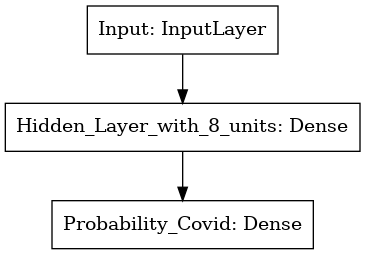

In [28]:
plot_model(model)

In [29]:
# Matriz de confusão pra treino
y_train_pred = model.predict(X_train)

In [30]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)

In [31]:
roc_auc = auc(fpr, tpr)

{'web': 'https://www.comet.ml/api/image/download?imageId=e0544248c32e482e92aa0479512e90ec&experimentKey=a465f772f087423a999abf28b6fd6a32',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=e0544248c32e482e92aa0479512e90ec&experimentKey=a465f772f087423a999abf28b6fd6a32',
 'imageId': 'e0544248c32e482e92aa0479512e90ec'}

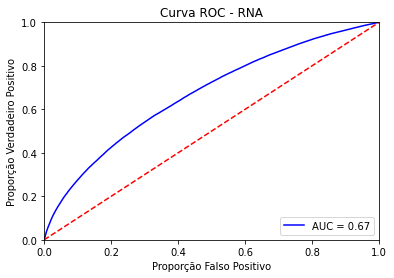

In [32]:
import matplotlib.pyplot as plt
plt.title('Curva ROC - RNA')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Proporção Verdadeiro Positivo')
plt.xlabel('Proporção Falso Positivo')
experiment.log_figure(figure=plt)

In [33]:
# Youden's J statistic to obtain the optimal probability threshold 
# This method gives equal weights to both false positives and false negatives.
optimal_proba_cutoff = sorted(list(zip(abs(tpr - fpr), thresholds)), key=lambda i: i[0], reverse=True)[0][1]
optimal_proba_cutoff

0.33383292

In [34]:
# Ponto de corte calculado a parte
optimal_proba_cutoff = 0.243121

In [36]:
y_train_pred_class = (y_train_pred > optimal_proba_cutoff)*1
cm_train = confusion_matrix(y_train, y_train_pred_class, labels = [0,1])
sens_train = cm_train[0,0]/(cm_train[0,0] + cm_train[1,0])
print('Sensibilidade do treino: '+ str(sens_train))
esp_train = cm_train[1,1]/(cm_train[1,1] + cm_train[0,1])
print('Especificidade do treino: '+ str(esp_train))

acc_train = (cm_train[0,0]+cm_train[1,1])/(cm_train[0,0]+cm_train[0,1]+cm_train[1,0]+cm_train[1,1])
print('Acurácia no banco de treino: ' + str(acc_train))

experiment.log_confusion_matrix(matrix = cm_train, labels=['Negative', 'Positive'],
                               title = 'Matriz de confusão para o banco de treino',
                               file_name='treino.json')
experiment.log_metrics({'Sensibilidade treino':sens_train,
                       'Especificidade treino':esp_train,
                       'Acurácia treino':acc_train})

Sensibilidade do treino: 0.8050581076794417
Especificidade do treino: 0.3978738688704702
Acurácia no banco de treino: 0.5180398881735437


In [37]:
# Matriz de confusão pra teste
y_test_pred = model.predict(X_test)
y_test_pred_class = (y_test_pred > optimal_proba_cutoff)*1
cm_test = confusion_matrix(y_test, y_test_pred_class, labels = [0,1])
sens_test = cm_test[0,0]/(cm_test[0,0] + cm_test[1,0])
print('Sensibilidade do teste: '+ str(sens_test))
esp_test = cm_test[1,1]/(cm_test[1,1] + cm_test[0,1])
print('Especificidade do teste: '+ str(esp_test))

acc_test = (cm_test[0,0]+cm_test[1,1])/(cm_test[0,0]+cm_test[0,1]+cm_test[1,0]+cm_test[1,1])
print('Acurácia no banco de teste: ' + str(acc_test))

experiment.log_confusion_matrix(matrix = cm_test, labels=['Negative', 'Positive'],
                               title = 'Matriz de confusão para o banco de teste',
                               file_name='teste.json')
experiment.log_metrics({'Sensibilidade teste':sens_test,
                       'Especificidade teste':esp_test,
                       'Acurácia teste':acc_test})

Sensibilidade do teste: 0.8340126216145148
Especificidade do teste: 0.3645509381979086
Acurácia no banco de teste: 0.5468819812344419


In [38]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/martinoni/mae5904-rna/a465f772f087423a999abf28b6fd6a32
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Acurácia teste             : 0.5468819812344419
COMET INFO:     Acurácia treino            : 0.5180398881735437
COMET INFO:     Especificidade teste       : 0.3645509381979086
COMET INFO:     Especificidade treino      : 0.3978738688704702
COMET INFO:     Sensibilidade teste        : 0.8340126216145148
COMET INFO:     Sensibilidade treino       : 0.8050581076794417
COMET INFO:     train_batch_loss [2300]    : (0.5657238960266113, 0.6770115494728088)
COMET INFO:     train_epoch_duration [100] : (0.29751787499844795, 0.7882380570008536)
COMET INFO:     train_loss [100]           : (0.5972791314125061, 0.6360152959823608)
COMET INFO:     t